In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, tan,pi,e

from cmath import asin
from cmath import sqrt,  exp
im = complex(0, 1)

In [2]:
from itertools import product

#### R calculation:

In [3]:
def transfer_matrix(N1, N2):
    tm = np.empty((2,2), dtype = np.complex)
    tm[0, 0] = (N2 + N1) / (2. * N2)
    tm[0, 1] = (N2 - N1) / (2. * N2)
    tm[1, 0] = (N2 - N1) / (2. * N2)
    tm[1, 1] = (N2 + N1) / (2. * N2)
    return tm

def N_calculation(n_first_media, incident_angle, n_current_media):
    return (n_current_media ** 2 - n_first_media ** 2 * (sin(incident_angle)) ** 2) ** 0.5

def phase_shift(d, N, k0):
    p_shift = np.empty((2, 2), dtype = np.complex)
    p_shift[0, 0] = exp(1.j * d * N * k0)
    p_shift[0, 1] = 0.+0.j
    p_shift[1, 0] = 0.+0.j
    p_shift[1, 1] = exp(-1.j * d * N * k0)
    return p_shift

def R_func(dictionary_structure={}, wl = 780, teta = 45):
    list_N = []

    T = np.eye(2, dtype=np.complex)
    tet = teta * np.pi / 180
    k0 = 2 * np.pi / wl
    n0 = complex(0., 0.)  # current n
    for i in range(0, len(dictionary_structure)):
        if i == 0:
            n0 = dictionary_structure[i]['n']
            list_N.append(N_calculation(n0, tet, n0))

        if dictionary_structure[i]['name'] == 'ФК':
            n1 = dictionary_structure[i]['n1']
            n2 = dictionary_structure[i]['n2']
            d1 = dictionary_structure[i]['d1']
            d2 = dictionary_structure[i]['d2']
            num_layers = int(dictionary_structure[i]['N'])
            N1 = N_calculation(n0, tet, n1)
            N2 = N_calculation(n0, tet, n2)
            from_upper_to_1 = transfer_matrix(list_N[-1], N1)
            from_1_to_2 = transfer_matrix(N1, N2)
            from_2_to_1 = transfer_matrix(N2, N1)
            F_n1 = phase_shift(d1, N1, k0)  # x1 - d, x2 - N, x3 - k0
            F_n2 = phase_shift(d2, N2, k0)          

            T = F_n2 @ from_1_to_2 @ F_n1 @ from_upper_to_1 @ T
            T_bilayer = F_n2 @from_1_to_2 @ F_n1 @from_2_to_1
            T = np.linalg.matrix_power(T_bilayer, num_layers - 1) @ T
            list_N.append(N1)
            list_N.append(N2)

        elif dictionary_structure[i]['name'] == 'Слой':
            n = dictionary_structure[i]['n']
            d = dictionary_structure[i]['d']
            N = N_calculation(n0, tet, n)
            from_this_to_next = transfer_matrix(list_N[-1], N)
            F = phase_shift(d, N, k0)
            T = np.dot(from_this_to_next, T)
            T = np.dot(F, T)
            list_N.append(N)

        elif dictionary_structure[i]['name'] == 'Среда':
            n = dictionary_structure[i]['n']
            N = N_calculation(n0, tet, n)
            from_last_to_sub = transfer_matrix(list_N[-1], N)
            T = np.dot(from_last_to_sub, T)
            list_N.append(N)
    return (-(T[1, 0] / T[1, 1]))


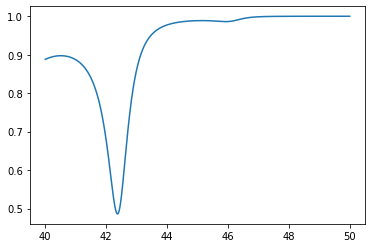

In [4]:
def decor(angles):
    wl = 780.
    didic = {
        0: {
            'name': 'Среда',
            'n': 1.5 + 0.j
        },
        1: {
            'name': 'Слой',
            'n': 1 + 0.j,
            'd': 300
        },  
        2: {
            'name': 'ФК',
            'n1': 1.45 + 0.j,
            'd1': 204.,
            'n2': 2.07+0.j,
            'd2': 143.,
            'N' : 10
        },
        3: {
            'name': 'Среда',
            'n': 1.52 + 0.j
        }
    }
    return abs(R_func(didic, wl, angles))

angles = np.linspace(40, 50, 100000)
vR = np.vectorize(decor)
res = vR(angles)
plt.plot(angles, res)

In [36]:
def spectral(a, k):
    return abs(a/(2 * np.sqrt(np.pi)) * np.exp(-a**2 * k**2 / 4))

#### a - значение координаты, по уровню 1/e. Полная ширина = 2a. 
#### N_x - число гармоник по k_x, которые будем использовать
#### Меньшая гармоника будет по амплитуде составлять не больше 1/100

##### (50a - ограничимся таким масштабом по х)

In [37]:
a = 10
L = 780
N_x = 200

k_min = abs(sqrt(16. / a**2))
k = 2 * np.pi * 1000000000 / 780
print("k_min = %f"%k_min)
print(k/1000000)

k_min = 0.400000
8.055365778435368


dk: 0.004
Угол сходимости, град: -2.84626935411


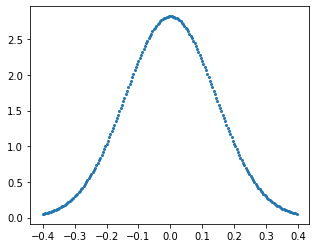

In [38]:
plt.figure(figsize=(5, 4))

dk_x = 2 * k_min / N_x

print("dk: " + str(dk_x))

k_n = np.arange(-N_x//2, N_x//2)
k_x = k_n * dk_x
S_k = []


for i in (k_x):
    y_max = spectral(a, i)
    S_k.append(y_max)
print("Угол сходимости, град: " + str(np.arcsin(k_x[0] * 1000000 / k).real * 180 / pi))
S_k = np.array(S_k)
plt.plot(k_x, S_k, 'o', markersize=2)

#### Прямая прогонка: рассчет прямого поля от падающего луча. Обратная прогонка рассчет отраженного луча. 
#### l - расстояние вдоль оси пучка, на которое мы недоюстировались. + - перефокусировка, -  - недофокусировка (желательно целое число микрон)
#### alpha - угол падения центральной спектральной компоненты 

In [58]:
'''
X - x-coordinate in micrometers
Z - z-coordinate in micrometers
E - electroagnetic field
'''

l_0 = -500  # расстояние вдоль оси пучка до сфокусированного
alpha = 45.9
h_0 = int(l_0 * cos(alpha * np.pi / 180)) # координата перетяжки над поверхностью слоя
x_0 = int(l_0 * sin(alpha * np.pi / 180)) # координата смещения перетяжки по х относительно нуля
x_offset = 400 # отступ луча слева в микронах, который рисуем
x_c_index = x_offset # положение центрального луча
if x_0 > x_offset:
    x_offset = x_0 - x_offset
else:
    x_offset = x_0 - x_offset
X = np.arange(x_offset, 1000 + x_offset, 1)
Z = np.arange(0, 1000, 1)
E = np.zeros((np.shape(Z)[0], np.shape(X)[0]), dtype=np.complex)
print(x_0, h_0, X[0])
#h_0 = int(abs(l_0 * cos(alpha * np.pi / 180))) - 1
#h = l * cos(alpha * np.pi / 180)


-359 -347 -759


In [60]:
%%time

rot_matrix = np.empty((2, 2), dtype = np.complex)
rot_matrix[0, 0] = cos(np.pi * alpha / 180)
rot_matrix[0, 1] = sin(np.pi * alpha / 180)
rot_matrix[1, 0] = sin(np.pi * alpha / 180)
rot_matrix[1, 1] = -cos(np.pi * alpha / 180)

tmp = np.empty((2, 1))

k_mkm = k / 1000000.;
k_z = k_mkm * np.cos(np.arcsin(k_x / k_mkm))
k_matrix = np.vstack((k_x.reshape((1, -1)), k_z.reshape((1, -1))))
s = S_k.reshape((-1, 1))
E = np.zeros((np.shape(Z)[0], np.shape(X)[0]), dtype=np.complex)

'''
Only matrix implementation (Runtime error, not enought memory?)
grid = np.array(list(product(X, Z - h)))
E = np.exp(1.0j * (grid @ rot_matrix) @ k_matrix, dtype=np.complex) @ s
'''

for j, z in enumerate(Z):
    for i, x in enumerate(X):
        tmp[0, 0] = x
        tmp[1, 0] = z - h_0
        E[j][i] = np.exp(1.0j * (rot_matrix @ tmp).T @ k_matrix, dtype=np.complex) @ s
    #print(j, "/", points)


CPU times: user 18.3 s, sys: 5.18 ms, total: 18.3 s
Wall time: 18.3 s


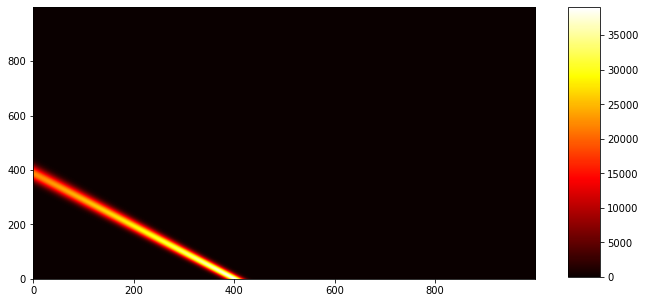

In [62]:
plt.figure(figsize=(9, 5))
plt.imshow(abs(E ** 2), cmap=plt.cm.hot, origin='lower', aspect='auto')    
#plt.xlim(46.6, 46.9)
cax = plt.axes([0.95, 0.13, 0.05, 0.75])
plt.colorbar(cax=cax)
plt.show()

In [172]:
R_teta = []
for number_k_x, t in enumerate(k_x):
    teta = asin(t * 1000000 / k).real
    #R_teta.append(1.)
    R_teta.append(R_func(teta=(alpha + teta * 180/pi) , wl=780, dictionary_structure=didic))
    
for j, current_Z in enumerate(Z):
    for i, current_X in enumerate(X):
        Sum = 0
        for number_k_x, t in enumerate(k_x):
            teta = asin(t * 1000000 / k).real
            k_z = k / 1000000 * cos(teta)
            #x_pos = current_X * cos(pi * 45.8 / 180) - current_Z * sin(pi * 45.8 / 180)
            #z_pos = current_X * cos(pi * 45.8 / 180) + current_Z * sin(pi * 45.8 / 180)
            
            x_pos = current_X * cos(pi * alpha / 180) + (-Z[j] - h) * sin(pi * alpha / 180)
            z_pos = current_X * sin(pi * alpha / 180) - (-Z[j] - h) * cos(pi * alpha / 180)
   
            Sum = Sum + S_k[number_k_x] * exp(im * t * x_pos) * exp(im * k_z * z_pos) * R_teta[number_k_x]
        E[j][i] = E[j][i] + Sum

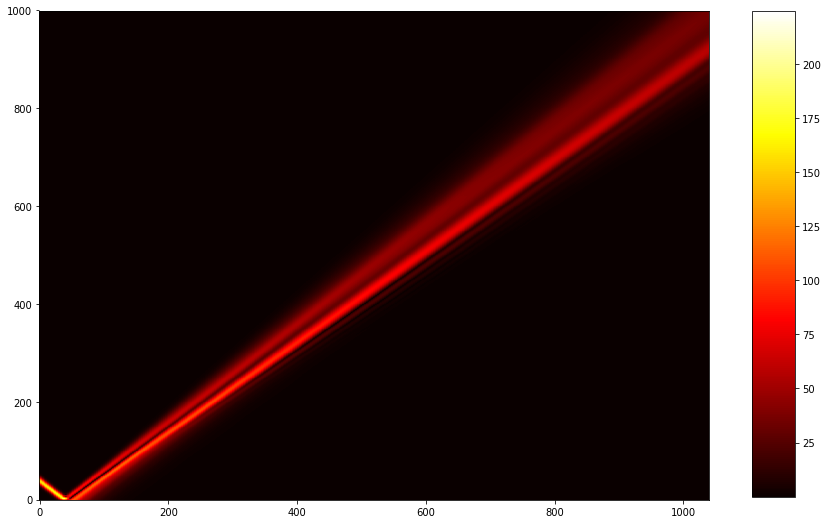

In [173]:
plt.figure(figsize=(12, 9))
plt.imshow(abs(E), cmap=plt.cm.hot, origin='lower', aspect='auto')    
#plt.xlim(46.6, 46.9)
cax = plt.axes([0.95, 0.13, 0.05, 0.75])
plt.colorbar(cax=cax)
plt.show()

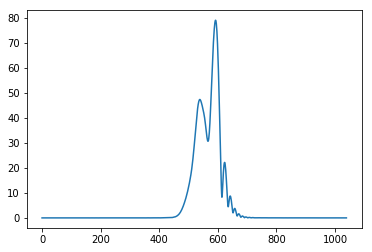

In [183]:
plt.plot(abs(E[500]))




In [176]:
fram = pd.DataFrame(data=abs(E))
fram.to_csv(r'c:\data\Gauss_5mcm_45.9_1040x1000.txt', header=None, index=None)

In [204]:
data = pd.read_csv("c:\data\Gauss_10mcm_45.9_1040x1000.txt", header=None)
plt.figure(figsize=(12, 9))
plt.imshow(data, cmap=plt.cm.hot, origin='lower', aspect='auto')    
#plt.xlim(46.6, 46.9)
cax = plt.axes([0.95, 0.13, 0.05, 0.75])
plt.colorbar(cax=cax)
plt.show()

In [ ]:
d_air = np.arange(0, 300, 1)


In [6]:
from tmm import examples as ex

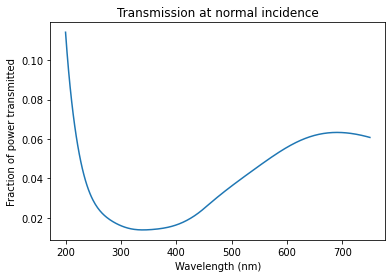

In [14]:
ex.sample2()